# Use REBOUND commit 6fb912f615ca542b670ab591375191d1ed914672

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import rebound
import dask.dataframe as dd
from scipy.stats import norm, ks_2samp
plt.style.use('paper')

In [5]:
csvpath = '../csvs/resonant/resonant_features/'
distpath = '../../stabilitydataset/data/resonant/simulation_archives/runs/'
df = pd.read_csv(csvpath + 'ressummaryfeatures.csv', index_col=0)
df = df[['ID', 'Mean', 'Sigma', 'KSpval']]
df.head()

,ID,Mean,Sigma,KSpval
3,3,6.837504,0.306543,0.403103
4,4,5.687568,0.239838,0.001330
5,5,5.797549,0.456784,0.930714
8,8,5.891151,0.417529,0.709091
13,13,4.644210,0.256174,0.000218


In [2]:
csvpath = '../csvs/resonant/resonant_features/'
distpath = '../../stabilitydataset/data/resonant/simulation_archives/runs/'

planet_systems = np.loadtxt(csvpath + "order.txt", dtype = str)

#FILTER DATA (between 1e4 and 1e7)
info = pd.read_csv("../csvs/resonant/Gaussian_Fits_317.csv")

#fully integrated data
short_feats = pd.read_csv("../csvs/resonant/deltatimes.csv")
subsystem = info["ID"].values.astype(int)
sub_short = short_feats.loc[subsystem]
print(sub_short.shape)

#filtered data params
filtered = sub_short[ (sub_short["t"]>1e4) & (sub_short["t"]<1e7) &
                    (sub_short["t_shadow"]>1e4 ) & (sub_short["t_shadow"]<1e7) ] 

print(filtered.shape)
filtered_inds = filtered.index
#df.loc[df['column_name'].isin(some_values)]
df = info.loc[info["ID"].isin(filtered_inds)] 
df["ID"] = df["ID"].values.astype(int)
df = df[['ID', 'Mean', 'Sigma']]
df.head()

(317, 3)
(145, 3)


/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if sys.path[0] == '':
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ID,Mean,Sigma
3,3,6.837504,0.306543
4,4,5.687568,0.239838
5,5,5.797549,0.456784
8,8,5.891151,0.417529
13,13,4.644210,0.256174


In [3]:
df.shape

(145, 3)

In [4]:
df = df[(df['Mean'] > 4) & (df['Mean'] < 7)]
df.shape

(136, 3)

In [5]:
labels = pd.read_csv('../../MLstability/training_data/resonant/labels.csv', index_col=0)
labels.head(15)

,runstring,instability_time,shadow_instability_time,Stable
0,0000000.bin,1.545872e+06,3.063700e+06,False
1,0000001.bin,9.990000e+08,9.990000e+08,True
2,0000002.bin,9.990000e+08,9.990000e+08,True
3,0000003.bin,2.287671e+06,8.392234e+06,False
4,0000004.bin,9.668931e+05,3.380350e+05,False
5,0000005.bin,5.755894e+05,5.459781e+04,False
6,0000006.bin,7.248372e+07,3.243220e+08,False
7,0000007.bin,2.225858e+04,6.193744e+03,False
8,0000008.bin,2.930966e+05,1.359759e+06,False
9,0000009.bin,3.484791e+05,9.534973e+05,False


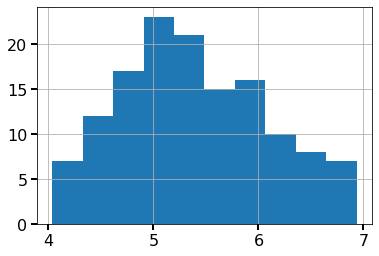

In [11]:
df['Mean'].hist()

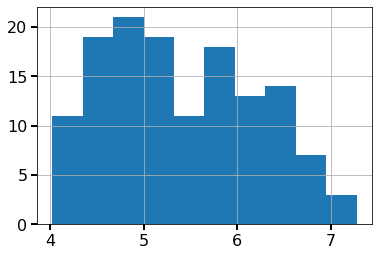

In [12]:
np.log10(labels.loc[df['ID']]['instability_time']).hist()

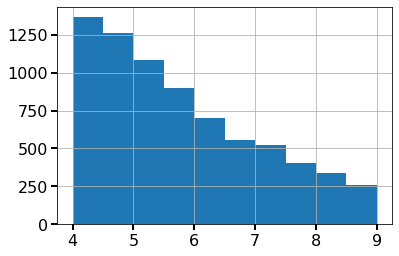

In [13]:
mask = (labels['instability_time']>1e4) & (labels['instability_time']<9.99e8)
np.log10(labels[mask]['instability_time']).hist()

In [14]:
mask.sum()/labels.shape[0]

0.74007400740074

In [6]:
def collision(reb_sim, col):
    reb_sim.contents._status = 5
    return 0

def runsplit(row):
    tmax = 1e7
    ID = int(row['ID'])
    row['instability_time'] = labels.loc[ID, 'instability_time']
    
    np.random.seed(3)
    # normal we want to match
    try:
        data =pd.read_csv(csvpath + "Res_sys_{0}_500.csv".format(ID), index_col = 0)
    except:
        data =pd.read_csv(csvpath + "Res_sys_{0}_1000.csv".format(ID), index_col = 0)
    del data["runstring"]
    data = data[data["t"]<1e8]
    data = np.log10(data["t"].values)
    test = np.random.normal(loc=row['Mean'], scale=row['Sigma'], size = data.shape[0])

    #ks test
    try:
        statistic, KSpval = ks_2samp(data, test)
    except:
        statistic, KSpval = 0,0
        
    row['KSpval'] = KSpval
    
    file = distpath+"sa{0:0=7d}.bin".format(ID)
    sim = rebound.SimulationArchive(file)[0]
    sim.ri_whfast.keep_unsynchronized = 1
    sim.collision_resolve=collision
    sim.init_megno(seed=0)

    Nout = 1000
    times = np.logspace(0, np.log10(tmax), Nout)
    P0 = sim.particles[1].P

    try:
        sim.integrate(row['instability_time']/10, exact_finish_time=0)
        row['tlyap10'] = 1/sim.calculate_lyapunov()/P0
        if row['tlyap10'] < 0 or row['tlyap10'] > sim.t:
            row['tlyap10'] = sim.t
        row['megno10'] = sim.calculate_megno()
        row['Nlyap10'] = row['instability_time']  / row['tlyap10']
    except:
        row['tlyap10'] = np.nan
        row['megno10'] = np.nan
        row['Nlyap10'] = np.nan
    
    return row

# We don't get exactly the same instability time when rerunning stopping along the way because the original integrations are using unsynced positions to detect collisions and megno syncs them. But that's fine. We always get very close, because it's once the orbits are crossing that we start finding collisions (synced or unsynced). This is a demonstration that the exact details of detecting collisions doesn't matter. We've also already checked reproducibility when we do a single sim.integrate (see test_notebooks) and here we just want the lyap times

In [36]:
row = df.loc[223]
tmax = 1e7
ID = int(row['ID'])
row['instability_time'] = labels.loc[ID, 'instability_time']

file = distpath+"sa{0:0=7d}.bin".format(ID)
sim = rebound.SimulationArchive(file)[0]
sim.ri_whfast.keep_unsynchronized = 1
sim.collision_resolve=collision
sim.init_megno(seed=0)

Nout = 1000
times = np.logspace(0, np.log10(tmax), Nout)
P0 = sim.particles[1].P

sim.integrate(row['instability_time']/3, exact_finish_time=0)
row['tlyap10'] = 1/sim.calculate_lyapunov()/P0
if row['tlyap10'] < 0 or row['tlyap10'] > sim.t:
    row['tlyap10'] = sim.t
row['megno10'] = sim.calculate_megno()
row['Nlyap10'] = row['instability_time']  / row['tlyap10']
sim.t/P0

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Escape: User caused exit. Simulation did not finish.

In [35]:
labels.loc[ID, 'instability_time']

11584.51005717814

# Generate

In [7]:
df = df.head(20)

In [ ]:
%%time
ddf = dd.from_pandas(df, npartitions=24)
testres = runsplit(df.iloc[0])
df = ddf.apply(runsplit, axis=1, meta=pd.DataFrame([testres])).compute(scheduler='processes')

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/pandas/core/series.py:1015: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc[key] = value
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simula

/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:89: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:138: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:138: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:89: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/work

In [23]:
df2 = pd.read_csv(csvpath+'res1e7featuressplit.csv', index_col=0)
df2.head()

,ID,Mean,Sigma,KSpval,instability_time,tlyap10,megno10,Nlyap10
3,3.0,6.837504,0.306543,0.403103,2.287671e+06,16155.249034,13.950857,141.605409
4,4.0,5.687568,0.239838,0.001330,9.668931e+05,96689.311474,2.104692,10.000000
5,5.0,5.797549,0.456784,0.930714,5.755894e+05,691.667984,80.773003,832.175823
8,8.0,5.891151,0.417529,0.709091,2.930966e+05,2362.272279,12.443361,124.074012
13,13.0,4.644210,0.256174,0.000218,4.506090e+04,4506.103381,2.022401,9.999969


In [24]:
df.head()

,ID,Mean,Sigma,instability_time,KSpval,tlyap10,megno10,Nlyap10
3,3.0,6.837504,0.306543,2.287671e+06,0.329358,16155.249034,13.950857,141.605409
4,4.0,5.687568,0.239838,9.668931e+05,0.000248,96689.311474,2.104692,10.000000
5,5.0,5.797549,0.456784,5.755894e+05,0.665922,691.667984,80.773003,832.175823
8,8.0,5.891151,0.417529,2.930966e+05,0.257607,2362.272279,12.443361,124.074012
13,13.0,4.644210,0.256174,4.506090e+04,0.000019,4506.103381,2.022401,9.999969


In [40]:
df.to_csv(csvpath+'res1e7featuressplit.csv')

In [15]:
np.log10(labels.loc[df[df['KSpval'] < 1.e-6]['ID']]['instability_time']).hist()

KeyError: 'KSpval'

In [27]:
ddf

,ID,Mean,Sigma,KSpval
npartitions=21,,,,
3,int64,float64,float64,float64
19,...,...,...,...
...,...,...,...,...
261,...,...,...,...
266,...,...,...,...


In [28]:
df.loc[223]

ID        2.420000e+02
Mean      2.903427e+00
Sigma     8.908058e-01
KSpval    4.330748e-08
Name: 223, dtype: float64

In [43]:
from scipy.stats import norm
def plot_hists(planet_systems):
    ncol, nrow = 3,len(planet_systems)//3+1
    fig, axarr = plt.subplots(ncols=ncol,nrows=nrow)
    fig.set_size_inches((15, nrow*3))
    for jj , planet_sys in enumerate(planet_systems[:ncol*nrow]):
        planet_sys  = int(planet_sys)
        try:
            data =pd.read_csv(csvpath+'Res_sys_{0}_500.csv'.format(planet_sys), index_col = 0)
        except:
            data =pd.read_csv(csvpath+'Res_sys_{0}_1000.csv'.format(planet_sys), index_col = 0)
        
        data = data[data["t"]<1e8]
        data["logt"] = np.log10(data["t"])
        name = str(planet_sys)
        # make guassian
        mean, sigma =  df[df["ID"]==int(name)][["Mean", "Sigma"]].values[0]

        x = np.linspace(mean - sigma*4, mean+sigma*4, 100)
        rv = norm(loc = mean, scale = sigma)
        axarr[jj//ncol, jj%ncol ].plot(x, rv.pdf(x), linewidth = 4, color = "black")
        
        data.hist("logt",  ax = axarr[jj//ncol, jj%ncol],  label = name, alpha = 0.7, normed = 1, color = "purple", edgecolor = "black", bins = 20)
        axarr[jj//ncol, jj%ncol ].set_title(name+"({0:.1f})".format(np.log10(df[df['ID'] == planet_sys]['KSpval']).values[0]))
        edges = axarr[jj//ncol, jj%ncol ].axes.get_ylim() 
        
    plt.show()
    plt.close(fig)

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/pandas/plotting/_core.py:2410: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(data[col].dropna().values, bins=bins, **kwds)


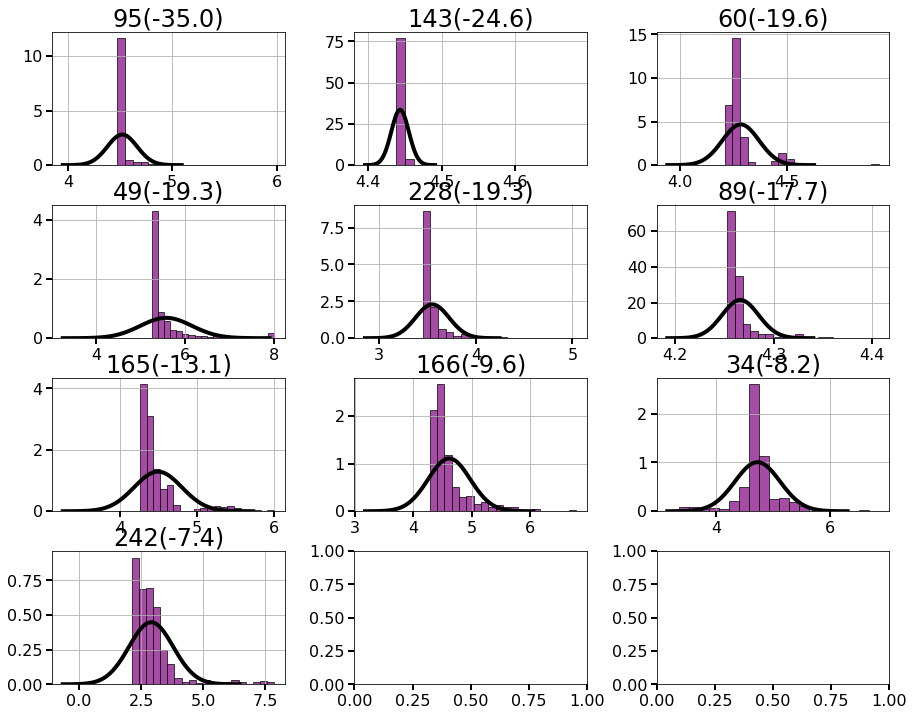

In [44]:
bad = df[df['KSpval'] < 1.e-6].sort_values(['KSpval'])
plot_hists(bad['ID'])

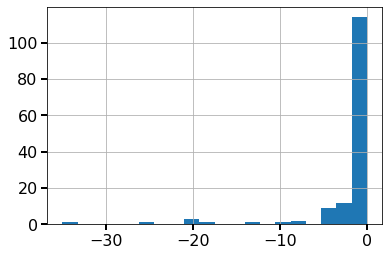

In [48]:
np.log10(df['KSpval']).hist(bins=20)

In [47]:
df['KSpval'].isnull().sum()

0

In [57]:
ID  = 49
file = distpath+"sa{0:0=7d}.bin".format(ID)
sim = rebound.SimulationArchive(file)[0]
    

/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:89: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:138: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:138: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


In [58]:
sim.status()

---------------------------------
REBOUND version:     	3.8.3
REBOUND built on:    	Sep  6 2019 15:43:52
Number of particles: 	4
Selected integrator: 	whfast
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.034641
---------------------------------
<rebound.Particle object, m=0.9999995455273081 x=-4.7298443749900997e-07 y=2.3452237398515157e-06 z=-2.8779986923394055e-08 vx=-9.994356612411258e-06 vy=-2.841671426067696e-06 vz=1.592760413664667e-07>
<rebound.Particle object, m=4.544726917462339e-07 x=0.9818659845399761 y=0.19089291910956893 z=-0.011300485084842203 vx=-1.1951381811149346 vy=6.164294538901315 vz=0.16345516127122856>
<rebound.Particle object, m=1.7367153653329138e-06 x=-0.07616371745604919 y=-1.264894977838715 z=0.018738387002718203 vx=5.516650631613658 vy=-0.3488925290197419 vz=-0.13577606294069386>
<rebound.Particle object, m=2.1454302472650466e-07 x=0.7412389389124681 y=-1.096357010670973 z=0.006397276680501152 vx=4.459048811079615 vy=3.0114874143152246